In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
from eval_util import *
from rec_util import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#Configuration

In [3]:
config = '/home/ellery/wikimedia/missing_articles/missing_articles.ini'
cp = SafeConfigParser()
cp.read(config)

embedding_dir = 'en_lda'
embedding_path = os.path.join(cp.get('general', 'local_data_dir'), embedding_dir)

s = 'en'
t = 'fr'
exp = 'frwiki'
campaign = '%s-recommender' % exp
exp_dir = '%s-%s' % (s, t)
exp_path = os.path.join(cp.get('general', 'local_data_dir'), exp_dir)


#Load Editor Contribution Data

In [4]:
e_random = pd.read_csv('/home/ellery/en-%s/e1.tsv' % t,  sep = '\t', encoding = 'utf8')
e_random.index = e_random['user']
e_personal = pd.read_csv('/home/ellery/en-%s/e2.tsv' % t,  sep = '\t', encoding = 'utf8')
e_personal.index = e_personal['user']

In [5]:
#e_personal = pd.read_csv('/home/ellery/en-%s/staff.tsv' % t,  sep = '\t', encoding = 'utf8')
#e_personal.columns = ['_', 'user', 'history', 'user_email']
#e_personal.index = e_personal['user']

# Refine and Split Articles

In [6]:
# load missing articles
translation_dict_file = os.path.join(exp_path, cp.get('missing', 'ranked_missing_items'))
a = pd.read_csv(translation_dict_file, sep = '\t', encoding = 'utf8')
a.index = a['id']
print "Num Missing Articles: ", a.shape[0]

Num Missing Articles:  3586858


In [7]:
# disambiguation
print "Num disambiguation", a['is_dis'].sum()
a = a[a['is_dis'] == False]
print "Num Missing Articles: ", a.shape[0]

Num disambiguation 60142
Num Missing Articles:  3526716


Stubs: 1503721
Full: 2022995


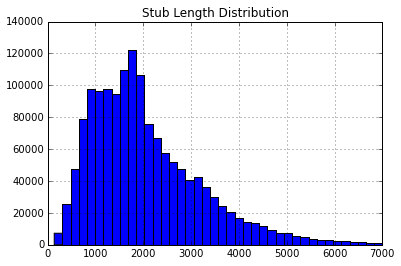

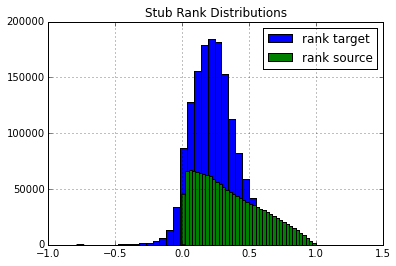

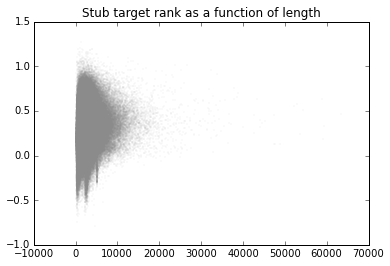

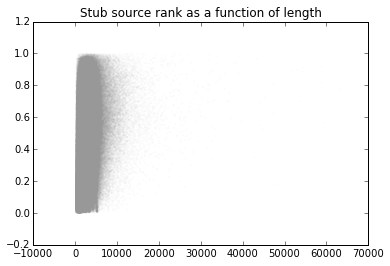

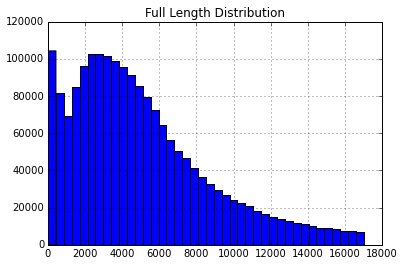

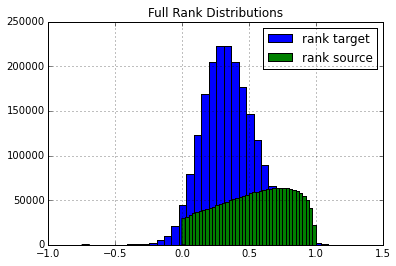

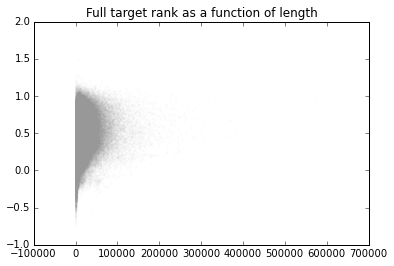

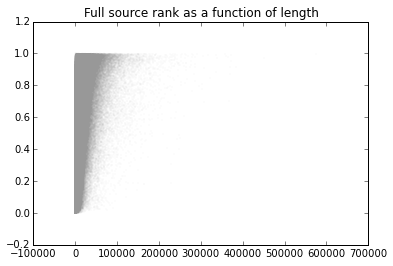

In [8]:
# remove short articles
plt.figure()

stub = a[a['is_stub']]
print "Stubs:", stub.shape[0]
full = a[~a['is_stub']]
print "Full:", full.shape[0]

# Investigate Stubs
plt.figure()
stub[stub['length'] < 7000]['length'].hist(bins = 40)
plt.title('Stub Length Distribution')

plt.figure()
stub['rank_t'].hist(bins = 40, label = 'rank target')
stub['rank_s'].hist(bins = 40, label = 'rank source')
plt.title('Stub Rank Distributions')
plt.legend()

plt.figure()
plt.scatter(stub['length'], stub['rank_t'], s=2, facecolor='0.5', lw = 0, alpha = 0.1)
plt.title('Stub target rank as a function of length')


plt.figure()
plt.scatter(stub['length'], stub['rank_s'], s=1, facecolor='0.5', lw = 0, alpha = 0.1)
plt.title('Stub source rank as a function of length')

#Investigat Full
plt.figure()
full[full['length'] < 17000]['length'].hist(bins = 40)
plt.title('Full Length Distribution')

plt.figure()
full['rank_t'].hist(bins = 40, label = 'rank target')
full['rank_s'].hist(bins = 40, label = 'rank source')
plt.title('Full Rank Distributions')
plt.legend()

plt.figure()
plt.scatter(full['length'], full['rank_t'], s=1, facecolor='0.5', lw = 0, alpha = 0.1)
plt.title('Full target rank as a function of length')


plt.figure()
plt.scatter(full['length'], full['rank_s'], s=1, facecolor='0.5', lw = 0, alpha = 0.1)
plt.title('Full source rank as a function of length')

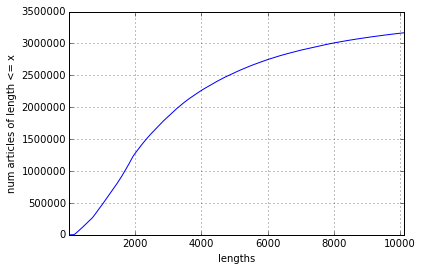

In [9]:
lengths = a['length'].value_counts()
lengths = lengths.sort_index()
lengths.cumsum()[:10000].plot()
plt.ylabel('num articles of length <= x')
plt.xlabel('lengths')

In [10]:
a = a[a['length'] > 1500]
print "Num Missing Articles: ", a.shape[0]

Num Missing Articles:  2693772


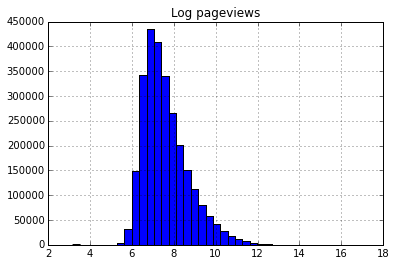

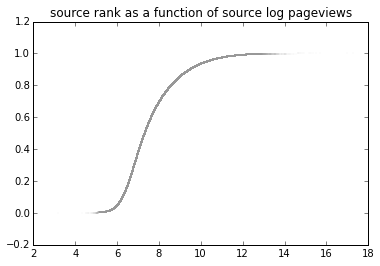

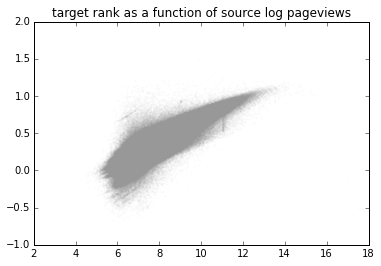

In [11]:
plt.figure()
a['log_pageview_count_s'].hist(bins = 40)
plt.title('Log pageviews')

plt.figure()
plt.scatter(a['log_pageview_count_s'], a['rank_s'], s=1, facecolor='0.5', lw = 0, alpha = 0.1)
plt.title('source rank as a function of source log pageviews')


plt.figure()
plt.scatter(a['log_pageview_count_s'], a['rank_t'], s=1, facecolor='0.5', lw = 0, alpha = 0.1)
plt.title('target rank as a function of source log pageviews')

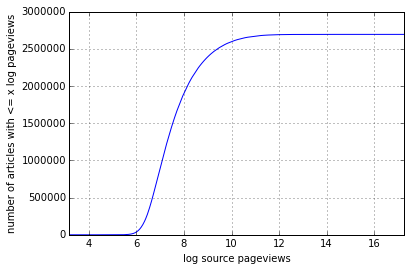

In [12]:
views = a['log_pageview_count_s'].value_counts()
views = views.sort_index()
views.cumsum().plot()
plt.xlabel('log source pageviews')
plt.ylabel('number of articles with <= x log pageviews')

In [13]:
thresh = 7.0
print np.exp(thresh)
(a['log_pageview_count_s'] > thresh).sum()

1096.63315843


1794114

In [14]:
a[a['log_pageview_count_s'] >= thresh][a['log_pageview_count_s'] <= thresh+0.1].head(10)

/home/ellery/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1808: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


,id,title_s,pageview_count_s,log_pageview_count_s,indx,rank_s,length,is_dis,is_stub,log_length,rank_t
id,,,,,,,,,,,
Q16105947,Q16105947,Geneviève_Hasenohr,1109,7.011214,2080375,0.382938,19655,False,False,9.886087,1.082361
Q17101990,Q17101990,Summary_and_map_of_the_2005_French_riots,1181,7.074117,3485153,0.408489,7886,False,False,8.972844,1.048163
Q2965273,Q2965273,Christian_Galliard_de_Lavernée,1154,7.050989,1141664,0.399092,4021,False,True,8.299286,1.036893
Q15438658,Q15438658,Jean_Max_Tixier,1118,7.019297,3131731,0.386257,5248,False,False,8.565602,1.012738
Q590608,Q590608,Matthieu_Marais,1136,7.035269,262482,0.392681,2976,False,False,7.998335,0.973985
Q2965084,Q2965084,Christian_Braut,1131,7.030857,1080207,0.390770,4701,False,True,8.455531,0.957428
Q6456005,Q6456005,L'Épervier,1106,7.008505,242967,0.381555,2049,False,True,7.625107,0.952787
Q1280236,Q1280236,Ecclesiam_a_Jesu_Christo,1128,7.028201,3685053,0.389687,6353,False,False,8.756682,0.947730
Q5392876,Q5392876,Ernest_Carbonne,1155,7.051856,2532149,0.399383,2947,False,False,7.988543,0.934435


In [15]:
a = a[a['log_pageview_count_s'] > thresh]
print "Num Missing Articles: ", a.shape[0]

Num Missing Articles:  1794114


In [16]:
# now create a stratified sample
a = a.sort('rank_t', ascending = False)
a_control = a.iloc[range(0, a.shape[0], 3)]
a_personal = a.iloc[range(1, a.shape[0], 3)]
a_random = a.iloc[range(2, a.shape[0], 3)]

#Load Doc Topic Matrices

In [17]:
embedding_dict_file = os.path.join(embedding_path, cp.get('LDA', 'article2index'))
id2index, index2id, id2uname = get_universal_maps(embedding_dict_file)
mm_file = os.path.join(embedding_path, cp.get('LDA', 'doc2topic'))
f = open(mm_file)
M = mmread(f).tocsr()
M = normalize(M, norm='l2', axis=1)

In [18]:
id2sname = dict(zip(a['id'], a['title_s']))

# Find Minimum Number of Articles:

Optimization took 1 seconds
0.660021880912
Optimization took 0 seconds
0.724353550348
Optimization took 0 seconds
0.749297967931
Optimization took 0 seconds
0.758604159856
Optimization took 0 seconds
0.763869624057
Optimization took 0 seconds
0.767194499154


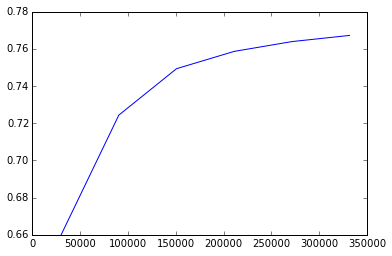

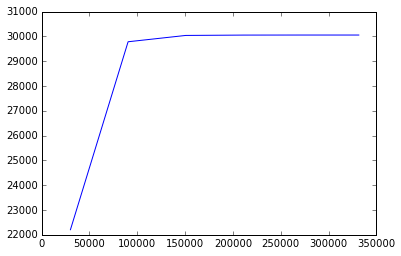

In [99]:
k = 5
greedy = True 
max_articles_per_editor = 1000
max_num_editors = e_personal.shape[0]
min_score = 0.4
mean_affinities = []
num_matches = []
num_editors = e_personal.shape[0]
n_articles = [k*num_editors * i for i in range(1, 12, 2)]

for n in n_articles:
    it = contribution_iter(e_personal['history'][:max_num_editors])
    a_personal_topn = a_personal[:n]
    id2importance = dict(zip(a_personal_topn['id'], np.ones(a_personal_topn.shape[0])))
    contributions = get_affinities(M,it, max_articles_per_editor, min_score, id2importance, id2index, index2id)
    if greedy:
        obj, d = greedy_match(contributions, k)
        print obj   
    else:
        editor_ids, article_ids, affinities = get_matching_data_structures(contributions)
        print "Number of Affinites", len (affinities)
        obj, d = match(editor_ids, article_ids, affinities, k )
    mean_affinities.append(obj)
    num_matches.append(d.shape[0])
    #print d

plt.figure()
plt.plot(n_articles, mean_affinities)
plt.figure()
plt.plot(n_articles, num_matches)

In [103]:
a_personal[90000:90010]

,id,title_s,pageview_count_s,log_pageview_count_s,indx,rank_s,length,is_dis,is_stub,log_length,rank_t
id,,,,,,,,,,,
Q1594009,Q1594009,"Heidelberg,_Gauteng",8314,9.025696,2550895,0.858213,4360,False,False,8.380227,0.605782
Q3709918,Q3709918,Alisha_Inacio,16239,9.695171,896975,0.916860,26819,False,False,10.196866,0.605780
Q4932347,Q4932347,Bob_Dylan_World_Tour_1966,11699,9.367259,1265888,0.891577,26966,False,False,10.202332,0.605775
Q17402876,Q17402876,Klapmeier_brothers,10523,9.261319,3719265,0.882073,67645,False,False,11.122029,0.605773
Q4353408,Q4353408,EMI_Films,10697,9.277719,2107524,0.883555,21871,False,False,9.992917,0.605772
Q3247782,Q3247782,Conservatoire_de_Luxembourg,2654,7.883823,3893050,0.668929,3266,False,True,8.091321,0.605771
Q5460833,Q5460833,Florence–Muscle_Shoals_metropolitan_area,12839,9.460243,2042091,0.899370,2504,False,True,7.825645,0.605769
Q1296931,Q1296931,Gorodki,8582,9.057422,2784051,0.861620,4535,False,False,8.419580,0.605768
Q794270,Q794270,Better_the_Devil_You_Know,16525,9.712630,2746692,0.918070,25147,False,False,10.132494,0.605767


#Perform Editor Article Assignment

In [68]:
n = 100000
k = 5
greedy = True 
max_articles_per_editor = 3000
min_score = 0.2
w = 15
it = contribution_iter(e_personal['history'])
a_personal_topn = a_personal[:n]
id2importance = dict(zip(a_personal_topn['id'], np.ones(a_personal_topn.shape[0])))
contributions = get_affinities(M,it, max_articles_per_editor, min_score, id2importance, id2index, index2id, w = w)
objective, d_personal = greedy_match(contributions, k)

print objective, d_personal.shape, e_personal.shape[0] * k

personal_objs = get_json(e_personal, d_personal, id2sname, contributions, campaign, s, t, k)
fname = "/home/ellery/%s/%s-personal-recs.json" % (exp_dir, exp)
with open(fname, 'w') as outfile:
    json.dump(personal_objs, outfile)
    
i = 0
for obj in personal_objs:
    pprint_rec(obj)
    i+=1
    if i==10:
        break
        
i = 0
for obj in personal_objs:
    pprint(obj)
    i+=1
    if i==10:
        break

Optimization took 0 seconds
0.728744968002 (30055, 3) 30145
There were 0 users without 5 recs
User: $traight-$hoota

History:

Schlüchtern
Rede_Integrada_de_Transporte
Iore
Fulda_(district)
Initialization-on-demand_holder_idiom
Fulda_station
World_Youth_Day_2008
EDAG
Joseph_Kentenich
We're_Going_to_Hang_out_the_Washing_on_the_Siegfried_Line
Flieden
Vance
Flieden
Theology_of_the_Body
Fulda_monastery

Recommendations:

Royal_train 0.812379743774
DRG_Class_61 0.746896772302
Höllentalbahn_(Black_Forest) 0.746358161666
DSB_Class_MY 0.736131354257
GWR_7800_Class 0.729932869324



User: 007Sam

History:

Matt_Dallas
Jean-Luc_Bilodeau
Chris_Olivero
Oleg_Prudius
Triple_H
Karim_Ziani
FIFA_100
Yohan_Cabaye
David_Bautista
Massimo_Busacca
Benjamin_Fall
Faouzi_Chaouchi
Zinédine_Zidane
Zinedine_Zidane

Recommendations:

2008_Coupe_de_France_Final 0.864327763309
1968_European_Cup_Final 0.856222540703
2014_Football_League_Cup_Final 0.829513354408
1996–97_Arsenal_F.C._season 0.798732696338
Heather_Cooke

# Create Random Recommendations

In [67]:
it = contribution_iter(e_random['history'])
contributions = {}
for i, contribution in enumerate(it):
    contribution['contributions'] = [d for d in contribution['contributions'] if d['id'] in id2index][-w:]
    contributions[contribution['uname']] = contribution


a_random_topn = a_random[:n]
a_random_topn = a_random_topn.iloc[np.random.permutation(len(a_random_topn))]
a_random_topn.reset_index(drop=True)

d_random = []
i = 0
for user in e_random.index:
    c = contributions[user]
    interest_vec = get_weighted_average_interest_vector(M, id2index, None, c)
    for j in range(k):
        doc_vec = np.asarray(M[ a_random_topn.iloc[i]['indx'], :].todense()).squeeze()
        score = interest_vec.dot(doc_vec)
        d_random.append((user, a_random_topn.iloc[i]['id'], score ))
        i+=1
d_random = pd.DataFrame(d_random)    
random_objs = get_json(e_random, d_random, id2sname, contributions, campaign, s, t, k)

fname = "/home/ellery/%s/%s-random-recs.json" % (exp_dir, exp)
with open(fname, 'w') as outfile:
    json.dump(random_objs, outfile)

    
i = 0
for obj in random_objs:
    pprint_rec(obj)
    i+=1
    if i==10:
        break
        
i = 0
for obj in random_objs:
    pprint(obj)
    i+=1
    if i==10:
        break

There were 0 users without 5 recs
User: (:Julien:)

History:

Saparmyrat_Nyýazow
Adrien_Moerman
Shaquille_O'Neal
Bruno_Julliard
Jeannette_Bougrab
Otan_(homonymie)
Tim_Duncan
Ion_Luca_Caragiale
Mongolie
Michael_Jackson
Parti_démocrate_(États-Unis)
Rocket_from_the_Crypt
Ahmed_Gaïd_Salah
Serge_Ibaka
Tchoukotka

Recommendations:

New_Series_Adventures 0.0234086731332
Westminster_College_(Missouri) 0.077981971992
The_Cyrkle 0.140586436845
Christianised_sites 0.112183127514
Bill_Medley 0.113764664897



User: -Roxas-

History:

Jonathan_Lipnicki
Blanc_(homonymie)
Luka_Modrić
Paul_Gauguin
Luigi_Luzzatti
Addition
Drapeau_de_la_Grèce
Real_Madrid
Prusse
Grand-duché_de_Toscane
All_Shall_Perish
Chiot
Cities_XL
TimeSplitters_4
Liste_des_épisodes_de_My_Little_Pony_:_Les_amies,_c'est_magique

Recommendations:

Wraparound_mortgage 0.135416233448
Spot_the_ball 0.0724982077572
Monster_Jam_World_Finals 0.0786620410353
Zoya_Afroz 0.0356532291271
Fifth_Business 0.123044889843



User: -Strogoff-

History:


In [69]:
a_control[:n].to_csv('/home/ellery/%s/%s-control_articles.csv' %  (exp_dir, exp), encoding = 'utf8', sep='\t')

#Scratch

In [61]:
d_random.head(10)

,0,1,2
0,Yakapedia,Q18085653,0.004883
1,Yakapedia,Q774838,0.071003
2,Yakapedia,Q17187983,0.131744
3,Yakapedia,Q6226934,0.028795
4,Yakapedia,Q5759483,0.039238
5,Euthy,Q46540,0.012560
6,Euthy,Q7049060,0.006843
7,Euthy,Q5539359,0.004850
8,Euthy,Q7744179,0.007980
9,Euthy,Q4357899,0.000000


In [62]:
#verify no repeat recs
d_personal.merge(d_random, on = 1, how='inner').shape

(0, 5)

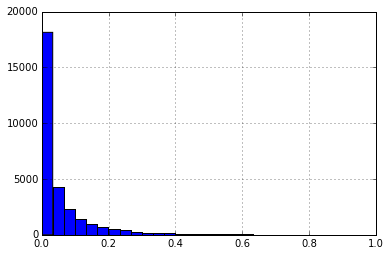

In [64]:
d_random[2].hist(bins = 30)

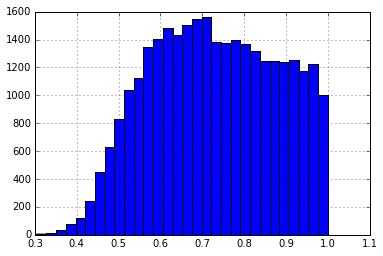

In [65]:
d_personal[2].hist(bins = 30)

In [ ]:
it = contribution_iter(e_random['history'])
tuples = []
for i, contribution in enumerate(it):
    pre = len(contribution['contributions'])
    post = len([d for d in contribution['contributions'] if d['id'] in id2index])
    tuples.append((pre, post))
   

In [ ]:
pp = pd.DataFrame(tuples)

In [ ]:
print sum(pp[0] == 0)

pp[0].hist()

In [ ]:
print sum(pp[1] == 0)
pp[1].hist(bins = 30)

In [ ]:
((pp[0] - pp[1]) / pp[0]).hist( bins = 50)